In [1]:
# Core libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Get rid of warnings

# Transformers and PEFT
from transformers import AutoTokenizer, AutoModel, BertConfig
from peft import LoraConfig, get_peft_model

# Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Utilities
import gc
from tqdm.auto import tqdm 

# Set style for prettier plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✓ All libraries imported successfully!")

/opt/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All libraries imported successfully!


In [2]:
config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = AutoModel.from_config(config)

In [23]:
# Read in the new sequence data and run head to see the overall data structure
data_in = pd.read_csv("data/sequence-cleaner.tsv", sep='\t') 
data_in.head

<bound method NDFrame.head of                genus        species  \
0      Kitasatospora        hibisci   
1     Peterkaempfera      podocarpi   
2       Streptomyces       citrinus   
3            Dickeya       ananatis   
4     Microbacterium       wangruii   
...              ...            ...   
6774     Selenomonas    ruminantium   
6775      Nonomuraea  roseoviolacea   
6776        Listeria       ivanovii   
6777    Streptomyces          albus   
6778   Mycobacterium          avium   

                                               sequence   identifier  \
0     TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...  NR_200017.1   
1     TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...  NR_200001.1   
2     AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...  NR_199987.1   
3     AAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGG...  NR_199979.1   
4     AGAGTTTGATCATGGCTCAGGATGAACGCTGGCGGCGTGCTTAACA...  NR_199966.1   
...                                                 ...          ... 

In [24]:
# Check the columns
print("Column 1:")
print(data_in.iloc[:, 0])
print("Column 2:")
print(data_in.iloc[:, 1])
print("Column 3:")
print(data_in.iloc[:, 2])

Column 1:
0        Kitasatospora
1       Peterkaempfera
2         Streptomyces
3              Dickeya
4       Microbacterium
             ...      
6774       Selenomonas
6775        Nonomuraea
6776          Listeria
6777      Streptomyces
6778     Mycobacterium
Name: genus, Length: 6779, dtype: object
Column 2:
0             hibisci
1           podocarpi
2            citrinus
3            ananatis
4            wangruii
            ...      
6774      ruminantium
6775    roseoviolacea
6776         ivanovii
6777            albus
6778            avium
Name: species, Length: 6779, dtype: object
Column 3:
0       TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...
1       TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...
2       AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...
3       AAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGG...
4       AGAGTTTGATCATGGCTCAGGATGAACGCTGGCGGCGTGCTTAACA...
                              ...                        
6774    ATGCAAGTCGAACGAGGTAATTGAAAGCTTGCTTT

In [25]:
data_in.sequence

0       TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...
1       TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...
2       AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...
3       AAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGG...
4       AGAGTTTGATCATGGCTCAGGATGAACGCTGGCGGCGTGCTTAACA...
                              ...                        
6774    ATGCAAGTCGAACGAGGTAATTGAAAGCTTGCTTTTGAGAACCGAG...
6775    TCGAGCGGCGAACGGGTGAGTAACACGTGAGCAACCTGCCCCTGAC...
6776    AATACATGCAAGTCGAACGAACGGAGGAAGAGCTTGCTCTTCCAAA...
6777    AACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGATGAACCCG...
6778    GACGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGGAAAG...
Name: sequence, Length: 6779, dtype: object

In [26]:
# Convert the new sequences to input tokens, view the first element
inputs = tokenizer(data_in.sequence.to_list())["input_ids"]
print(inputs[0])

[1, 115, 174, 222, 23, 177, 143, 33, 166, 403, 247, 123, 150, 527, 2759, 2834, 52, 919, 72, 103, 254, 30, 841, 72, 61, 68, 1695, 328, 54, 205, 3358, 1016, 519, 45, 72, 1200, 137, 1339, 252, 64, 209, 266, 788, 103, 45, 241, 745, 111, 914, 36, 118, 2139, 1587, 316, 97, 679, 628, 76, 1138, 3924, 1834, 136, 2063, 2553, 229, 201, 2369, 100, 72, 755, 78, 1527, 71, 148, 30, 200, 43, 763, 97, 409, 876, 111, 405, 169, 1419, 117, 2275, 64, 72, 31, 120, 559, 607, 200, 25, 1818, 61, 72, 1392, 151, 706, 443, 79, 37, 123, 619, 36, 247, 137, 194, 351, 93, 764, 90, 57, 110, 354, 120, 212, 16, 522, 72, 74, 685, 41, 33, 964, 1220, 15, 150, 102, 15, 220, 51, 93, 1527, 253, 37, 2548, 522, 329, 16, 482, 3434, 315, 103, 265, 159, 113, 591, 57, 140, 103, 19, 259, 174, 304, 229, 3810, 118, 622, 1538, 577, 117, 841, 203, 24, 113, 205, 35, 553, 169, 120, 134, 200, 681, 48, 1138, 3154, 270, 41, 103, 1078, 233, 159, 84, 31, 102, 1149, 282, 1435, 3274, 280, 386, 482, 846, 599, 159, 801, 708, 1788, 540, 10, 93, 547

In [27]:
# Set all random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

print("✓ Random seeds set for reproducibility")

✓ Random seeds set for reproducibility


In [28]:
# Helper function to count trainable parameters
def print_trainable_parameters(model):
    """Count and display trainable vs total parameters."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    
    trainable_pct = 100 * trainable_params / all_param
    print(f"  Trainable params: {trainable_params:,}")
    print(f"  Total params: {all_param:,}")
    print(f"  Trainable: {trainable_pct:.2f}%")

# Configure LoRA
lora_config = LoraConfig(
    r=8,                              # Rank (lower = fewer params)
    lora_alpha=32,                    # Scaling factor
    target_modules=["query", "value"], # Adapt attention layers
    lora_dropout=0.1,                 # Regularization
    bias="none",                      # Don't adapt bias terms
)

# Apply LoRA to the model
print("🔄 Applying LoRA adapters to model...\n")
ft_model = get_peft_model(model, lora_config)

print("📊 Model Parameters Comparison:")
print("-" * 60)
print("Before LoRA (original model):")
print_trainable_parameters(model)
print("\nAfter LoRA (adapted model):")
print_trainable_parameters(ft_model)
print("-" * 60)
print("\n✓ LoRA adapters applied successfully!")

🔄 Applying LoRA adapters to model...

📊 Model Parameters Comparison:
------------------------------------------------------------
Before LoRA (original model):
  Trainable params: 294,912
  Total params: 89,481,984
  Trainable: 0.33%

After LoRA (adapted model):
  Trainable params: 294,912
  Total params: 89,481,984
  Trainable: 0.33%
------------------------------------------------------------

✓ LoRA adapters applied successfully!


In [29]:
# Create the train-val-test splits
# Configuration
prop_train = 0.8
prop_val = 0.1
prop_test = 0.1
SEED = 42

# Create random splits
rng = np.random.default_rng(SEED)
random_idxs = rng.permutation(len(data_in))

# Calculate split sizes
n_total = len(data_in)
n_train = int(prop_train * n_total)
n_val = int(prop_val * n_total)

train_df = data_in.iloc[random_idxs[:n_train]]
val_df = data_in.iloc[random_idxs[n_train:n_train + n_val]]
test_df = data_in.iloc[random_idxs[n_train + n_val:]]

In [30]:
# Custom PyTorch Dataset for protein sequences
class SequenceDataset(Dataset):
    """
    Dataset class that tokenizes protein sequences on-the-fly.
    """
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sequence = row["sequence"]
        label = torch.tensor(row["genus"], dtype=torch.float32)

        # Tokenize sequence
        inputs = self.tokenizer(
            sequence,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
        )
        # Remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

print("✓ SequenceDataset class defined")

✓ SequenceDataset class defined


In [31]:
# Create dataset instances
train_dataset = SequenceDataset(train_df, tokenizer)
val_dataset = SequenceDataset(val_df, tokenizer)
test_dataset = SequenceDataset(test_df, tokenizer)

print("✓ Datasets created:")
print(f"  Train: {len(train_dataset):,} samples")
print(f"  Val: {len(val_dataset):,} samples")
print(f"  Test: {len(test_dataset):,} samples")

✓ Datasets created:
  Train: 5,423 samples
  Val: 677 samples
  Test: 679 samples


In [32]:
# Training configuration
BATCH_SIZE = 128  
LEARNING_RATE = 2e-4
NUM_WORKERS = 8
NUM_EPOCHS = 40

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =============================================================================
# Step 1: Create Label Encodings for Species
# =============================================================================

# Encode species names as integers
label_encoder = LabelEncoder()
label_encoder.fit(data_in['genus'])

# Add encoded labels to dataframes
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df['genus_encoded'] = label_encoder.transform(train_df['genus'])
val_df['genus_encoded'] = label_encoder.transform(val_df['genus'])
test_df['genus_encoded'] = label_encoder.transform(test_df['genus'])

num_classes = len(label_encoder.classes_)
print(f"\n✓ Label encoding complete:")
print(f"  Number of unique species: {num_classes}")
print(f"  Example: '{label_encoder.classes_[0]}' -> {0}")

# =============================================================================
# Step 2: Update Dataset Class for Classification
# =============================================================================
class SequenceClassificationDataset(Dataset):
    """
    Dataset class for species classification with integer labels.
    """
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sequence = row["sequence"]
        label = torch.tensor(row["genus_encoded"], dtype=torch.long)  # Long for classification

        # Tokenize sequence
        inputs = self.tokenizer(
            sequence,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )
        # Remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

Using device: cuda

✓ Label encoding complete:
  Number of unique species: 222
  Example: 'Acetobacter' -> 0


In [33]:
# Create Classification Model with LoRA
class DNABERTClassifier(nn.Module):
    """
    Combines LoRA-adapted DNABERT with classification head.
    """
    def __init__(self, base_model, num_classes, hidden_size=768):
        super().__init__()
        self.base_model = base_model  # LoRA-wrapped DNABERT
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None, **kwargs):
        # Get embeddings from DNABERT
        outputs = self.base_model(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        # Use [CLS] token representation (first token)
        cls_output = outputs.last_hidden_state[:, 0, :]
        
        # Apply dropout and classification head
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        
        return logits

In [34]:
# Instantiate Model
classification_model = DNABERTClassifier(
    base_model=ft_model,  # LoRA-adapted model
    num_classes=num_classes,
    hidden_size=768  # DNABERT-2-117M hidden size
).to(device)

print("\n🎯 Complete Model Architecture:")
print("-" * 60)
print_trainable_parameters(classification_model)
print("-" * 60)

# Create DataLoaders
train_dataset = SequenceClassificationDataset(train_df, tokenizer)
val_dataset = SequenceClassificationDataset(val_df, tokenizer)
test_dataset = SequenceClassificationDataset(test_df, tokenizer)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

print(f"\n✓ DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


🎯 Complete Model Architecture:
------------------------------------------------------------
  Trainable params: 465,630
  Total params: 89,652,702
  Trainable: 0.52%
------------------------------------------------------------

✓ DataLoaders created:
  Train batches: 43
  Val batches: 6
  Test batches: 6


In [35]:
# Setup Training Components
# Optimizer - only update trainable parameters
optimizer = AdamW(
    filter(lambda p: p.requires_grad, classification_model.parameters()), 
    lr=LEARNING_RATE,
    weight_decay=0.01
)

# Loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Learning rate scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print("\n✓ Training setup complete!")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE})")
print(f"  Loss: CrossEntropyLoss")
print(f"  Scheduler: CosineAnnealingLR")


✓ Training setup complete!
  Optimizer: AdamW (lr=0.0002)
  Loss: CrossEntropyLoss
  Scheduler: CosineAnnealingLR


In [36]:
# Training Loop
def train_epoch(model, loader, optimizer, loss_fn, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc="Training")
    for inputs, labels in progress_bar:
        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(**inputs)
        loss = loss_fn(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        predictions = logits.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    return total_loss / len(loader), correct / total

def evaluate(model, loader, loss_fn, device):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            
            logits = model(**inputs)
            loss = loss_fn(logits, labels)
            
            total_loss += loss.item()
            predictions = logits.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(loader), correct / total


In [37]:
# Train the model and record training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("\n" + "=" * 60)
print("🚀 Starting Training!")
print("=" * 60)

best_val_acc = 0.0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_epoch(
        classification_model, train_loader, optimizer, loss_fn, device
    )
    
    # Validate
    val_loss, val_acc = evaluate(
        classification_model, val_loader, loss_fn, device
    )
    
    # Update scheduler
    scheduler.step()
    
    # Store metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"\n📊 Epoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc * 100:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(classification_model.state_dict(), 'best_model_cleanerfile.pt')
        print(f"  ✓ New best model saved! (Val Acc: {val_acc * 100:.2f}%)")

print("\n" + "=" * 60)
print("✓ Training Complete!")
print("=" * 60)
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")


🚀 Starting Training!

Epoch 1/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]



📊 Epoch 1 Summary:
  Train Loss: 4.9311 | Train Acc: 13.20%
  Val Loss: 4.8393 | Val Acc: 14.33%
  ✓ New best model saved! (Val Acc: 14.33%)

Epoch 2/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]



📊 Epoch 2 Summary:
  Train Loss: 4.7629 | Train Acc: 15.05%
  Val Loss: 4.7766 | Val Acc: 14.33%

Epoch 3/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]



📊 Epoch 3 Summary:
  Train Loss: 4.5462 | Train Acc: 15.91%
  Val Loss: 4.4561 | Val Acc: 18.91%
  ✓ New best model saved! (Val Acc: 18.91%)

Epoch 4/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]



📊 Epoch 4 Summary:
  Train Loss: 4.1424 | Train Acc: 22.18%
  Val Loss: 3.9929 | Val Acc: 23.04%
  ✓ New best model saved! (Val Acc: 23.04%)

Epoch 5/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]



📊 Epoch 5 Summary:
  Train Loss: 3.7556 | Train Acc: 26.44%
  Val Loss: 3.6334 | Val Acc: 26.74%
  ✓ New best model saved! (Val Acc: 26.74%)

Epoch 6/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]



📊 Epoch 6 Summary:
  Train Loss: 3.3504 | Train Acc: 31.75%
  Val Loss: 3.0436 | Val Acc: 35.30%
  ✓ New best model saved! (Val Acc: 35.30%)

Epoch 7/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]



📊 Epoch 7 Summary:
  Train Loss: 2.8772 | Train Acc: 38.98%
  Val Loss: 2.5981 | Val Acc: 41.06%
  ✓ New best model saved! (Val Acc: 41.06%)

Epoch 8/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]



📊 Epoch 8 Summary:
  Train Loss: 2.4034 | Train Acc: 47.32%
  Val Loss: 2.1765 | Val Acc: 46.53%
  ✓ New best model saved! (Val Acc: 46.53%)

Epoch 9/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]



📊 Epoch 9 Summary:
  Train Loss: 1.9942 | Train Acc: 54.95%
  Val Loss: 1.8198 | Val Acc: 51.99%
  ✓ New best model saved! (Val Acc: 51.99%)

Epoch 10/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]



📊 Epoch 10 Summary:
  Train Loss: 1.6752 | Train Acc: 60.80%
  Val Loss: 1.5496 | Val Acc: 59.53%
  ✓ New best model saved! (Val Acc: 59.53%)

Epoch 11/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]



📊 Epoch 11 Summary:
  Train Loss: 1.4186 | Train Acc: 67.53%
  Val Loss: 1.3228 | Val Acc: 66.17%
  ✓ New best model saved! (Val Acc: 66.17%)

Epoch 12/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]



📊 Epoch 12 Summary:
  Train Loss: 1.2187 | Train Acc: 72.97%
  Val Loss: 1.1329 | Val Acc: 72.82%
  ✓ New best model saved! (Val Acc: 72.82%)

Epoch 13/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]



📊 Epoch 13 Summary:
  Train Loss: 1.0522 | Train Acc: 77.54%
  Val Loss: 0.9861 | Val Acc: 75.78%
  ✓ New best model saved! (Val Acc: 75.78%)

Epoch 14/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]



📊 Epoch 14 Summary:
  Train Loss: 0.9152 | Train Acc: 81.32%
  Val Loss: 0.8814 | Val Acc: 78.43%
  ✓ New best model saved! (Val Acc: 78.43%)

Epoch 15/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]



📊 Epoch 15 Summary:
  Train Loss: 0.8009 | Train Acc: 83.72%
  Val Loss: 0.7779 | Val Acc: 81.24%
  ✓ New best model saved! (Val Acc: 81.24%)

Epoch 16/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]



📊 Epoch 16 Summary:
  Train Loss: 0.7160 | Train Acc: 86.54%
  Val Loss: 0.7095 | Val Acc: 82.13%
  ✓ New best model saved! (Val Acc: 82.13%)

Epoch 17/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]



📊 Epoch 17 Summary:
  Train Loss: 0.6411 | Train Acc: 87.83%
  Val Loss: 0.6394 | Val Acc: 84.34%
  ✓ New best model saved! (Val Acc: 84.34%)

Epoch 18/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]



📊 Epoch 18 Summary:
  Train Loss: 0.5745 | Train Acc: 89.67%
  Val Loss: 0.5953 | Val Acc: 85.38%
  ✓ New best model saved! (Val Acc: 85.38%)

Epoch 19/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]



📊 Epoch 19 Summary:
  Train Loss: 0.5274 | Train Acc: 90.63%
  Val Loss: 0.5499 | Val Acc: 86.56%
  ✓ New best model saved! (Val Acc: 86.56%)

Epoch 20/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]



📊 Epoch 20 Summary:
  Train Loss: 0.4893 | Train Acc: 91.17%
  Val Loss: 0.5230 | Val Acc: 86.41%

Epoch 21/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]



📊 Epoch 21 Summary:
  Train Loss: 0.4440 | Train Acc: 92.40%
  Val Loss: 0.4935 | Val Acc: 87.59%
  ✓ New best model saved! (Val Acc: 87.59%)

Epoch 22/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]



📊 Epoch 22 Summary:
  Train Loss: 0.4230 | Train Acc: 92.73%
  Val Loss: 0.4674 | Val Acc: 88.33%
  ✓ New best model saved! (Val Acc: 88.33%)

Epoch 23/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]



📊 Epoch 23 Summary:
  Train Loss: 0.3937 | Train Acc: 93.27%
  Val Loss: 0.4547 | Val Acc: 87.89%

Epoch 24/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]



📊 Epoch 24 Summary:
  Train Loss: 0.3738 | Train Acc: 94.03%
  Val Loss: 0.4328 | Val Acc: 88.18%

Epoch 25/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]



📊 Epoch 25 Summary:
  Train Loss: 0.3553 | Train Acc: 94.67%
  Val Loss: 0.4151 | Val Acc: 89.07%
  ✓ New best model saved! (Val Acc: 89.07%)

Epoch 26/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]



📊 Epoch 26 Summary:
  Train Loss: 0.3435 | Train Acc: 94.91%
  Val Loss: 0.4093 | Val Acc: 89.07%

Epoch 27/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]



📊 Epoch 27 Summary:
  Train Loss: 0.3309 | Train Acc: 94.62%
  Val Loss: 0.3983 | Val Acc: 88.63%

Epoch 28/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]



📊 Epoch 28 Summary:
  Train Loss: 0.3176 | Train Acc: 95.26%
  Val Loss: 0.3899 | Val Acc: 89.66%
  ✓ New best model saved! (Val Acc: 89.66%)

Epoch 29/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]



📊 Epoch 29 Summary:
  Train Loss: 0.3102 | Train Acc: 95.59%
  Val Loss: 0.3873 | Val Acc: 89.07%

Epoch 30/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]



📊 Epoch 30 Summary:
  Train Loss: 0.2986 | Train Acc: 95.72%
  Val Loss: 0.3806 | Val Acc: 89.36%

Epoch 31/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]



📊 Epoch 31 Summary:
  Train Loss: 0.2946 | Train Acc: 96.07%
  Val Loss: 0.3751 | Val Acc: 89.81%
  ✓ New best model saved! (Val Acc: 89.81%)

Epoch 32/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]



📊 Epoch 32 Summary:
  Train Loss: 0.2893 | Train Acc: 95.94%
  Val Loss: 0.3740 | Val Acc: 89.81%

Epoch 33/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]



📊 Epoch 33 Summary:
  Train Loss: 0.2890 | Train Acc: 95.87%
  Val Loss: 0.3696 | Val Acc: 89.96%
  ✓ New best model saved! (Val Acc: 89.96%)

Epoch 34/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]



📊 Epoch 34 Summary:
  Train Loss: 0.2855 | Train Acc: 95.70%
  Val Loss: 0.3668 | Val Acc: 90.10%
  ✓ New best model saved! (Val Acc: 90.10%)

Epoch 35/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]



📊 Epoch 35 Summary:
  Train Loss: 0.2755 | Train Acc: 95.85%
  Val Loss: 0.3641 | Val Acc: 90.25%
  ✓ New best model saved! (Val Acc: 90.25%)

Epoch 36/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]



📊 Epoch 36 Summary:
  Train Loss: 0.2769 | Train Acc: 96.04%
  Val Loss: 0.3640 | Val Acc: 90.25%

Epoch 37/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]



📊 Epoch 37 Summary:
  Train Loss: 0.2734 | Train Acc: 95.92%
  Val Loss: 0.3631 | Val Acc: 89.81%

Epoch 38/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]



📊 Epoch 38 Summary:
  Train Loss: 0.2748 | Train Acc: 95.98%
  Val Loss: 0.3627 | Val Acc: 90.25%

Epoch 39/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]



📊 Epoch 39 Summary:
  Train Loss: 0.2721 | Train Acc: 95.98%
  Val Loss: 0.3625 | Val Acc: 90.25%

Epoch 40/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]



📊 Epoch 40 Summary:
  Train Loss: 0.2731 | Train Acc: 96.16%
  Val Loss: 0.3624 | Val Acc: 90.25%

✓ Training Complete!
Best Validation Accuracy: 90.25%


/tmp/ipykernel_143398/1429672769.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classification_model.load_state_dict(torch.load('best_model_cleanerfile.pt'))



🧪 Evaluating on test set...


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]



📈 Final Test Results:
  Test Loss: 0.3232
  Test Accuracy: 92.78%


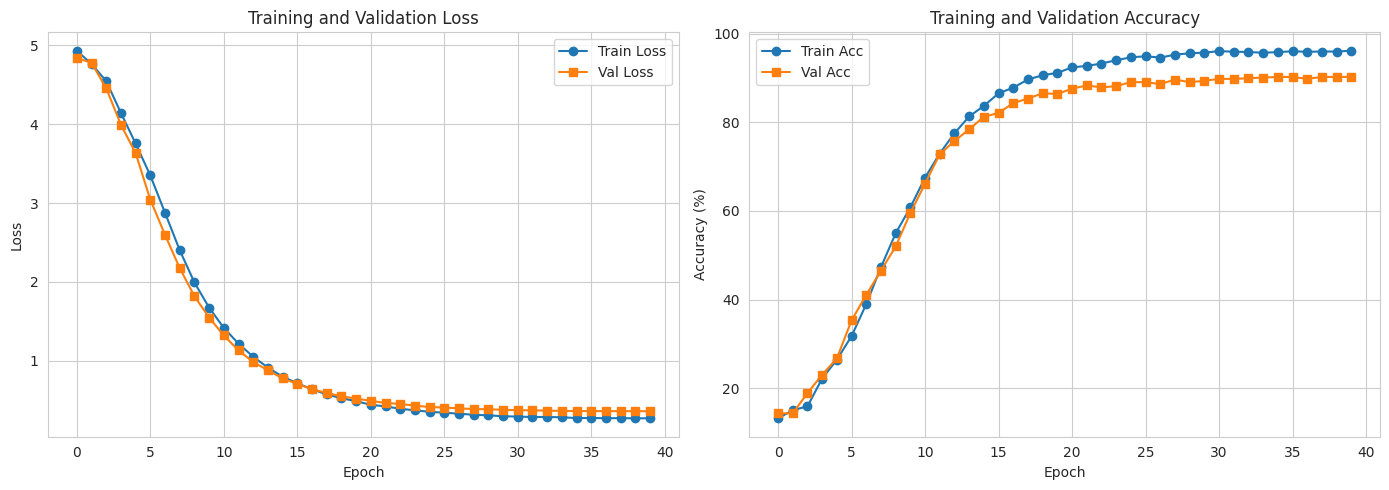


✓ Training history plot saved as 'training_history.png'


In [39]:
# Final Evaluation on Test Set
print("\n🧪 Evaluating on test set...")
classification_model.load_state_dict(torch.load('best_model_cleanerfile.pt'))
test_loss, test_acc = evaluate(classification_model, test_loader, loss_fn, device)

print(f"\n📈 Final Test Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")

# Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot([acc * 100 for acc in history['train_acc']], label='Train Acc', marker='o')
ax2.plot([acc * 100 for acc in history['val_acc']], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training history plot saved as 'training_history.png'")

In [40]:
# Try loading the model
loaded_model = torch.load('best_model_cleanerfile.pt', weights_only=False)